# Case Study 4.2: Songs Recommender

Instructor:
Activity Type: Optional 
Case Study Description: Building your own recommendation system for songs, like the examples discussed for Spotify. Recommend New Songs to users based on their listening habits
Why this Case Study? By following some simple steps you can develop your own version of a recommendation engine which forms the basis of several content recommendation systems, e.g., Netflix, Pandora, Spotify. You can now apply this acquired skill to all sorts of domains of your choice, e.g., restaurant recommendations.
Self-Help Documentation: In this document, we walk through some helpful tips to get you started with building your own Recommendation engine based on the case studies discussed in the Recommendation systems module. In this tutorial, we provide examples and some pseudo-code for the following programming environments: R, Python. 

Download Self-Help Documentation

## References:


https://blogs.gartner.com/martin-kihn/how-to-build-a-recommender-system-in-python/


https://blog.cambridgespark.com/nowadays-recommender-systems-are-used-to-personalize-your-experience-on-the-web-telling-you-what-120f39b89c3c


https://towardsdatascience.com/create-music-recommendation-system-using-python-ce5401317159

https://www.youtube.com/watch?v=18adykNGhHU&feature=youtu.be

http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

https://github.com/ajohannsdottir/Tutorials/blob/master/Implementing%20your%20own%20recommender%20systems%20in%20Python%20.ipynb

https://github.com/kaihuang201/recommender/blob/master/recommender.py


https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch10_Analyzing_Music_Trends_and_Recommendations/Recommendation%20Engines.ipynb

https://github.com/DataSorcerer/Music-Recommendation-System/blob/master/SVD_Helper.py

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib
import math as mt
from scipy.sparse import csc_matrix


import seaborn as sns
import squarify
from sklearn import metrics
import Recommenders as Recommenders
import Evaluation as Evaluation



%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Getting Data

In [2]:
dataset = pd.read_table('songs.txt', names=['user_id', 'song_id', 'listen_count'])
song_data = pd.read_csv('song_data.csv')

In [3]:
dataset.head(5)

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [4]:
song_data.head(5)

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [5]:
#dataset.drop('listen_count', axis = 1, inplace=True)

In [6]:
dataset.head(5)

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


## Processing

In [7]:
data = pd.merge(dataset, song_data, on='song_id')

In [8]:
data.head(5)

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,The Cove,Thicker Than Water,Jack Johnson,0
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,The Cove,Thicker Than Water,Jack Johnson,0


In [9]:
sparsity = len(data) / (data.song_id.nunique() * data.user_id.nunique() ) * 100
print ('sparsity is :', sparsity )

sparsity is : 0.27332861839089495


In [10]:
data.shape

(2086946, 7)

In [11]:
#Reducing sparsity
grouped = data.groupby('user_id')
user_greater50 = grouped.filter(lambda x: len(x) > 50)

In [12]:
user_greater50.head(5)

,user_id,song_id,listen_count,title,release,artist_name,year
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,The Cove,Thicker Than Water,Jack Johnson,0
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,The Cove,Thicker Than Water,Jack Johnson,0
6,b4a678fb729bfca6031a96948996ea909ca06fe5,SOAKIMP12A8C130995,2,The Cove,Thicker Than Water,Jack Johnson,0


In [13]:
user_greater50.shape

(946216, 7)

In [14]:
users = user_greater50.user_id.nunique()
print ("Users: ", users)

Users:  10439


In [15]:
songs = user_greater50.song_id.nunique()
print ("Songs: ", songs)

Songs:  10000


In [16]:
#Merging song title and artistname
user_greater50['song'] = user_greater50['title'] + ' - ' + user_greater50['artist_name']

In [17]:
user_greater50.head(5)

,user_id,song_id,listen_count,title,release,artist_name,year,song
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Jack Johnson
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Jack Johnson
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Jack Johnson
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Jack Johnson
6,b4a678fb729bfca6031a96948996ea909ca06fe5,SOAKIMP12A8C130995,2,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Jack Johnson


## Exploring

### Top 10 - Popular Songs

In [18]:
popular_songs = user_greater50.groupby(['title']).agg({'listen_count': 'count'}).reset_index()
popular_songs = popular_songs.sort_values(['listen_count', 'title'], ascending = [0,1]).head(10)

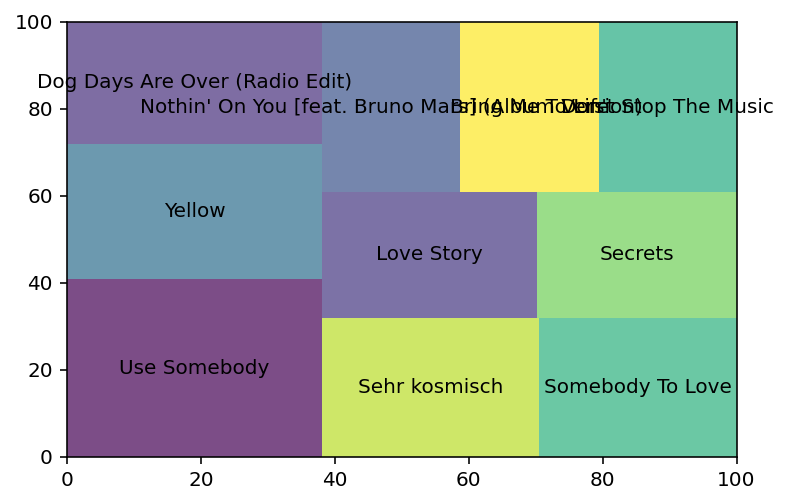

<Figure size 1440x1080 with 0 Axes>

In [19]:
volume = popular_songs.listen_count
labels = popular_songs.title

squarify.plot(sizes=volume, label=labels,
              alpha=0.7)

plt.figure(figsize=(20, 15))

plt.show()

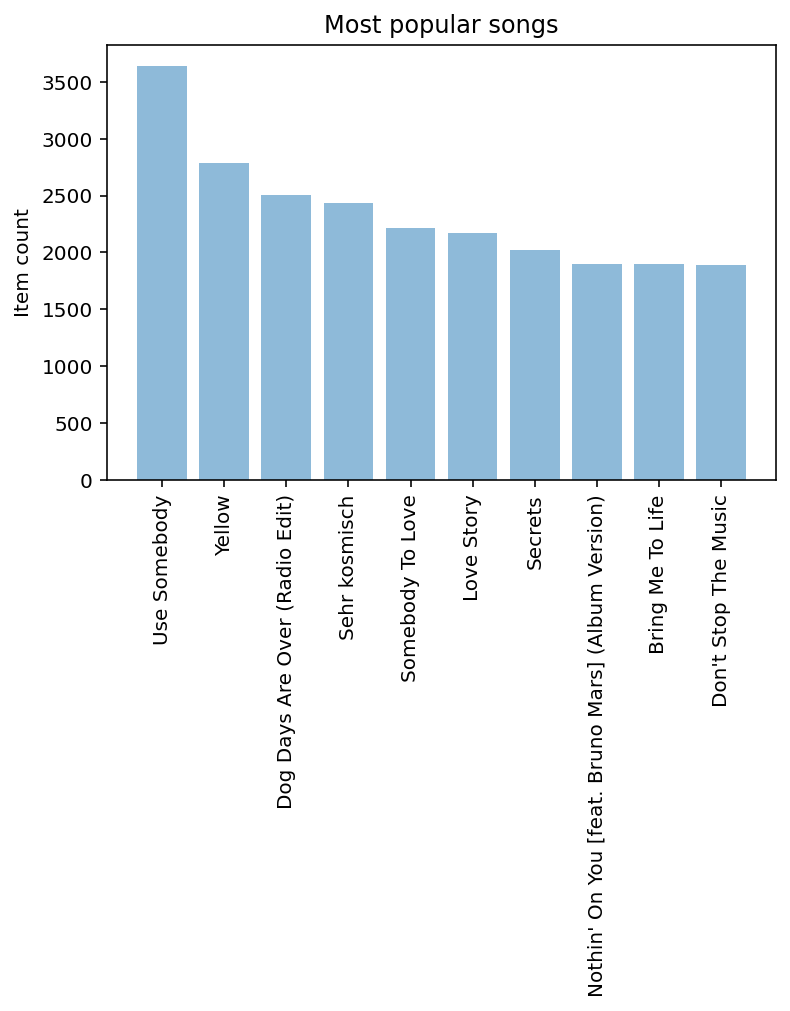

In [20]:

objects = (list(popular_songs['title']))
y_pos = np.arange(len(objects))
performance = list(popular_songs['listen_count'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular songs')
 
plt.show()

### Top 10 - Artists

In [21]:
popular_artists = user_greater50.groupby(['artist_name']).agg({'listen_count': 'count'}).reset_index()
popular_artists = popular_artists.sort_values(['listen_count', 'artist_name'], ascending = [0,1]).head(10)

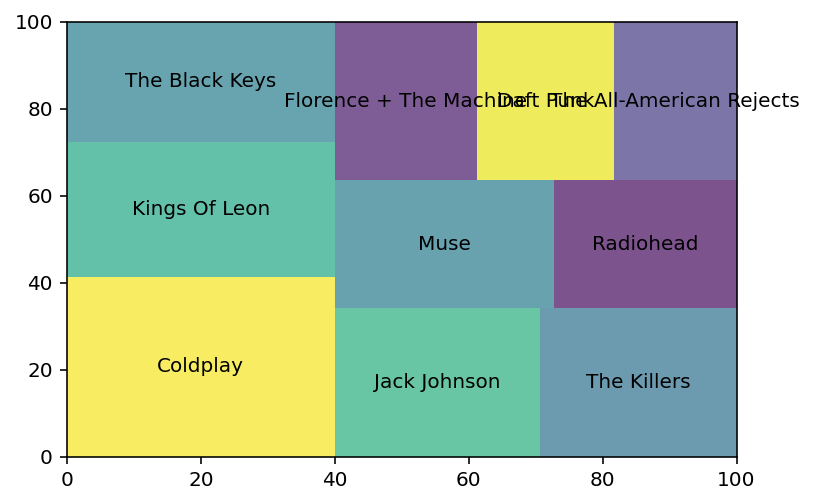

<Figure size 1440x1080 with 0 Axes>

In [22]:
volume = popular_artists.listen_count
labels = popular_artists.artist_name

squarify.plot(sizes=volume, label=labels,
              alpha=0.7)

plt.figure(figsize=(20, 15))

plt.show()

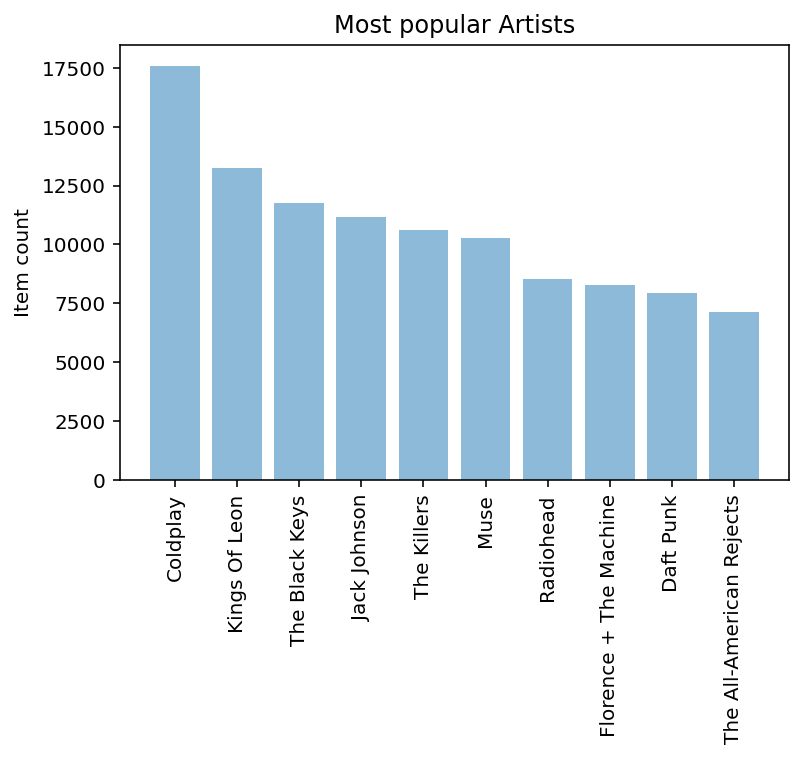

In [23]:
objects = (list(popular_artists['artist_name']))
y_pos = np.arange(len(objects))
performance = list(popular_artists['listen_count'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Artists')
 
plt.show()

## Recommendation by Popularity

In [24]:
song_grouped = user_greater50.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
9168,Use Somebody - Kings Of Leon,3642,0.384902
9782,Yellow - Coldplay,2786,0.294436
2075,Dog Days Are Over (Radio Edit) - Florence + Th...,2505,0.264739
7150,Sehr kosmisch - Harmonia,2433,0.257129
7564,Somebody To Love - Justin Bieber,2164,0.228700
...,...,...,...
5952,Now Behold The Lamb - Kirk Franklin & The Family,9,0.000951
9255,Waimea Bay - Jan & Dean,9,0.000951
9144,Untitled #5 - John Frusciante,8,0.000845
5616,My Generation - Di-rect,7,0.000740


In [25]:
# Splitting the data

from sklearn.model_selection import train_test_split


# Splitinto training and testing sets
X_train, X_test = train_test_split(user_greater50, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

recommended_popularity = X_train.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
train_popular_songs = recommended_popularity.sort_values(['listen_count', 'song'], ascending = [0,1]).head(10)

In [26]:
X_train.head()

,user_id,song_id,listen_count,title,release,artist_name,year,song
1068824,c7800ec9ad2d6596dde760ef900629e0c7c17836,SOBQXRB12AB01834D2,1,My Mom,Relapse: Refill,Eminem,2009,My Mom - Eminem
678378,9de6ffaecf494afdb90a0f678156437485a1674a,SOAKMDU12A8C1346A9,1,Such Great Heights,Grey's Anatomy Original Soundtrack,The Postal Service,2003,Such Great Heights - The Postal Service
1723495,7fe307489b419b1cbde61ccd42d1c5f7e850683a,SOPJWVJ12A6D4FA182,1,Babylon,Rock 'N Roll,The New York Dolls,1974,Babylon - The New York Dolls
870139,6a9cf03dfb2fc82f5b3b043c9c3fdbab997fd54d,SOGKAYF12A81C204CD,2,Good Life,Graduation,Kanye West / T-Pain,2007,Good Life - Kanye West / T-Pain
948715,861bc8945890dbfa0ba641686decb8855c8dbb12,SOICKOC12A6701C603,1,Blurry,Come Clean,Puddle Of Mudd,2001,Blurry - Puddle Of Mudd


In [27]:
trained_grouped = pd.DataFrame(X_train.groupby('song_id')['listen_count'].count())
trained_grouped

,listen_count
song_id,
SOAAAGQ12A8C1420C8,30
SOAACPJ12A81C21360,77
SOAACSG12AB018DC80,15
SOAAEJI12AB0188AB5,25
SOAAFAC12A67ADF7EB,76
...,...
SOZZTNF12A8C139916,82
SOZZVWB12AB0189C30,56
SOZZWZV12A67AE140F,43


In [28]:
#song example
song_example = 'SOJZXJQ12A6310F132'
songs_crosstab = pd.pivot_table(X_train, values = 'listen_count', index = 'user_id', columns = 'song_id')
print(songs_crosstab.shape)
songs_crosstab.head()

(10439, 10000)


song_id,SOAAAGQ12A8C1420C8,SOAACPJ12A81C21360,SOAACSG12AB018DC80,SOAAEJI12AB0188AB5,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAJMQ12A6D4F7D17,SOAAKPM12A58A77210,SOAALWN12A6D4F7FDA,SOAAMOW12AB018149B,...,SOZZKPR12A6D4F8147,SOZZLTY12A67AE0AD0,SOZZLZN12A8AE48D6D,SOZZRHE12A6702165F,SOZZTCU12AB0182C58,SOZZTNF12A8C139916,SOZZVWB12AB0189C30,SOZZWZV12A67AE140F,SOZZYAO12A6701FF36,SOZZZPV12A8C1444B5
user_id,,,,,,,,,,,,,,,,,,,,,
000e2c2a8c7870ff9121f212b35c8b3a20cc0e67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000ebc858861aca26bac9b49f650ed424cf882fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00185e316f07f0f00c325ca034be59c15b362401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002543003041db1d049206b09426d5cdffc0f451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0028292aa536122c1f86fd48a39bd83fe582d27f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
predictor_song_ratings = songs_crosstab[song_example]
predictor_song_ratings[predictor_song_ratings>= 1]

user_id
041938328349ad365521e740a55223d4176449a6    1.0
048ab89499425cdf386b244698e6b40a187411d3    2.0
062f6e577bd19d933c21165aa631f5e5fb5071c3    1.0
0c0c8a34c1b917c8aa65ab64e828124881cc1835    1.0
0fd300d92e6d650cc6e15bce0819c1fe7537bee1    1.0
                                           ... 
f3335939ed42796879c93da0cd4c8f567a409f8d    1.0
f99ebb2f0170a186a2a692e49559a2c643a98b73    2.0
fb02c1dd485e55c64668c42f6bee2d19bbff5d6c    1.0
fbee1c8ce1a346fa07d2ef648cec81117438b91f    3.0
fc3360c5a95f851785240111560e0fa266928fea    2.0
Name: SOJZXJQ12A6310F132, Length: 79, dtype: float64

In [30]:
similar_songs = songs_crosstab.corrwith(predictor_song_ratings)

/Users/claudiogimenestoledo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/claudiogimenestoledo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [31]:
similar_songs.head()

song_id
SOAAAGQ12A8C1420C8   NaN
SOAACPJ12A81C21360   NaN
SOAACSG12AB018DC80   NaN
SOAAEJI12AB0188AB5   NaN
SOAAFAC12A67ADF7EB   NaN
dtype: float64

In [32]:
corr_listened_song = pd.DataFrame(similar_songs, columns = ['pearsonR'])
corr_listened_song.dropna(inplace = True)
print (corr_listened_song.shape)
corr_listened_song.head()

(809, 1)


,pearsonR
song_id,
SOAAFYH12A8C13717A,0.802955
SOABRAB12A6D4F7AAF,1.000000
SOACPBY12A8C13FEF9,-0.250000
SOADISH12AB018DFAC,-0.067015
SOADJQJ12A8C141D38,0.937937


In [33]:

predictor_corr_summary = corr_listened_song.join(trained_grouped['listen_count'])
predictor_corr_summary = predictor_corr_summary.sort_values('pearsonR', ascending = False)

predictor_corr_summary.head()

,pearsonR,listen_count
song_id,,
SOZZFTH12A6701E983,1.0,43
SOFAJJB12B350582B8,1.0,30
SOSEKZA12A8C13FF24,1.0,102
SOEIJIX12A6D4FAF6E,1.0,83
SORVHGJ12AB01883C4,1.0,104


In [34]:
final_recommended_songs = predictor_corr_summary[predictor_corr_summary.pearsonR < 0.9999]
final_recommended_songs.sort_values('pearsonR', ascending = False)
final_recommended_songs = final_recommended_songs.reset_index()
final_recommended_songs.head()

,song_id,pearsonR,listen_count
0,SOUGCDK12AC95F075F,0.999622,390
1,SOELOOM12AB017DB4C,0.996616,262
2,SOVHVBJ12A58A7AB0A,0.995871,344
3,SOJEVHC12A8C13C3E5,0.994850,259
4,SOUMOMJ12A6701DFDC,0.993399,221


In [35]:
song_df_one = X_train.drop(['listen_count'], axis=1)

## Recommended by correlation

In [36]:
similar_songs = pd.merge(final_recommended_songs, song_df_one.drop_duplicates(["song_id"]), on="song_id", how="left")
similar_songs = similar_songs.sort_values('pearsonR', ascending = False)
similar_songs.head(50)

,song_id,pearsonR,listen_count,user_id,title,release,artist_name,year,song
0,SOUGCDK12AC95F075F,0.999622,390,62d68e726ccbcaf847100e78bbcc8dfc3bbd05a1,Never Let You Go,My Worlds,Justin Bieber,2010,Never Let You Go - Justin Bieber
1,SOELOOM12AB017DB4C,0.996616,262,2aa75979bf0b02aeceb7b41019994ab1b3306ab8,Gimme Sympathy,Gimme Sympathy,Metric,2009,Gimme Sympathy - Metric
2,SOVHVBJ12A58A7AB0A,0.995871,344,506783fab1597240ee762797f80e6633f1cc2ff9,The Way Things Go,Identification Parade,Octopus Project,2002,The Way Things Go - Octopus Project
3,SOJEVHC12A8C13C3E5,0.994850,259,ed7110f943d63aff393d7130604c410f3f50d8fb,Flume,For Emma_ Forever Ago,Bon Iver,2007,Flume - Bon Iver
4,SOUMOMJ12A6701DFDC,0.993399,221,14473c5b1461a49747d6d3efea02fafcd5ec883f,The News,Brushfire Fairytales,Jack Johnson,2000,The News - Jack Johnson
5,SOEGIYH12A6D4FC0E3,0.991020,1155,4659c7dc2755135360aeb76964b8e716d31f663b,Horn Concerto No. 4 in E flat K495: II. Romanc...,Mozart - Eine kleine Nachtmusik,Barry Tuckwell/Academy of St Martin-in-the-Fie...,0,Horn Concerto No. 4 in E flat K495: II. Romanc...
6,SOQYMNH12A8C137AA0,0.989743,111,c65a346ab8f41fb56926b503ece810f358b0d241,First Breath After Coma,The Earth Is Not A Cold Dead Place,Explosions In The Sky,2003,First Breath After Coma - Explosions In The Sky
7,SONDJCU12AB017B729,0.981981,144,0743ec0eed5ba591e6af50d04a55f3961b0a748c,Windmill Wedding,No Way Down,Air France,2008,Windmill Wedding - Air France
8,SOVHZVI12A8C14398A,0.981981,131,8bf93d0caf9ef925733cab66e84ce56c9d0c44dc,No Way Down,No Way Down,Air France,2008,No Way Down - Air France
9,SOUYMPF12A58A7C78A,0.980196,224,ad7f99f6dbe2ce32cd7d2cd77a95936b58275eb3,Polite Dance Song,Ray Guns Are Not Just The Future,the bird and the bee,2007,Polite Dance Song - the bird and the bee


In [37]:
X_train[X_train['song_id'] == song_example]

,user_id,song_id,listen_count,title,release,artist_name,year,song
1776913,2c2f150207963aaec11a5de532f0a5eccfd1121b,SOJZXJQ12A6310F132,1,Help Is Round The Corner,Yellow,Coldplay,2000,Help Is Round The Corner - Coldplay
1776888,041938328349ad365521e740a55223d4176449a6,SOJZXJQ12A6310F132,1,Help Is Round The Corner,Yellow,Coldplay,2000,Help Is Round The Corner - Coldplay
1776885,0fd300d92e6d650cc6e15bce0819c1fe7537bee1,SOJZXJQ12A6310F132,1,Help Is Round The Corner,Yellow,Coldplay,2000,Help Is Round The Corner - Coldplay
1776874,91d2254f8f929a87267d1b1726337eb3eb3710d4,SOJZXJQ12A6310F132,1,Help Is Round The Corner,Yellow,Coldplay,2000,Help Is Round The Corner - Coldplay
1776886,ae8f6aa483e702b0cf4c1886b0eaae024533f62a,SOJZXJQ12A6310F132,1,Help Is Round The Corner,Yellow,Coldplay,2000,Help Is Round The Corner - Coldplay
...,...,...,...,...,...,...,...,...
1776849,4c1f297e729d37b4fdc080095d0cb5d19416018b,SOJZXJQ12A6310F132,1,Help Is Round The Corner,Yellow,Coldplay,2000,Help Is Round The Corner - Coldplay
1776882,e5fd6dab18092f7bbb0c57275b88951d6c2226c3,SOJZXJQ12A6310F132,1,Help Is Round The Corner,Yellow,Coldplay,2000,Help Is Round The Corner - Coldplay
1776875,0c0c8a34c1b917c8aa65ab64e828124881cc1835,SOJZXJQ12A6310F132,1,Help Is Round The Corner,Yellow,Coldplay,2000,Help Is Round The Corner - Coldplay
1776923,635d29adefb7ea3971941010cdd9b0b23e4670fb,SOJZXJQ12A6310F132,1,Help Is Round The Corner,Yellow,Coldplay,2000,Help Is Round The Corner - Coldplay


## User and Song - Collaborative Filtering

In [38]:
songs_crosstab_train = pd.pivot_table(X_train, values = 'listen_count', index = 'user_id', columns = 'song_id')
songs_crosstab_train.fillna(0,inplace=True)

songs_crosstab_test = pd.pivot_table(X_test, values = 'listen_count', index = 'user_id', columns = 'song_id')
songs_crosstab_test.fillna(0,inplace=True)

In [39]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(songs_crosstab_train, metric='cosine')
song_similarity = pairwise_distances(songs_crosstab_train.T, metric='cosine')

In [40]:
def predict(data, similarity, mode):
    # mask: bit array indicating whether the item is rated
    mask = np.copy(data)
    mask[data > 0] = 1

    if mode == 'song_id':
        pred = data.dot(similarity) / mask.dot(np.abs(similarity))
    else:
        # User filtering
        mean = data.sum(1) / (data!=0).sum(1)
        diff = data - np.multiply(mean[:, np.newaxis], mask)
        # Old prediction rule:
        #pred = similarity.dot(data) / np.array([np.abs(similarity).sum(axis=1)]).T
        # dotting the mask excluds un-rated entried
        pred = mean[:, np.newaxis] + similarity.dot(diff) / (np.abs(similarity)).T.dot(mask)

    return pred

In [41]:
print ("Getting the song predictions")
song_prediction = predict(songs_crosstab_train, song_similarity, 'song_id')

print ("Getting the user predictions")
user_prediction = predict(songs_crosstab_train, user_similarity, 'user_id')

Getting the song predictions
Getting the user predictions


In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def evaluate(data, predictions):
    prediction = predictions[data.nonzero()].flatten()
    data = data[data.nonzero()].flatten()


    return sqrt(mean_squared_error(data, np.abs(prediction)))

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [43]:
evaluate(songs_crosstab_test.to_numpy(), user_prediction )

5.359821044683318

In [44]:
song_prediction.columns = songs_crosstab_train.columns

In [45]:
song_prediction[song_example].sort_values(ascending=False)

user_id
2231cb435771a1a621ec44e95cdd28b81fad3288    38.106830
70e67e9db6a3d494d4c817cb379901b488584a1f    30.377260
972cce803aa7beceaa7d0039e4c7c0ff097e4d55    27.924938
46474cad92820165fa5a866b708df6e26f1e8eda    27.133597
4be63160ad51eb4c19c3ba70bf097b729d929650    24.054005
                                              ...    
710549fd28a1b36c1556b5ee85473add19f7ee41     1.000000
88b7253a9425e3a78bbcfd266ea35fcc1c3a12c1     1.000000
d1d5d7d1657a70cc1666ff69808eaa88c8aaf0c6     1.000000
8caff18a8ae39903eb855982daf02d977e5ae438     1.000000
9554e6a8b359875a91ac6923a94ebc8fc849e77e     1.000000
Name: SOJZXJQ12A6310F132, Length: 10439, dtype: float64

## SVD - Matrix Factorization based Recommendation

In [46]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(songs_crosstab_train, k = 50)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print ('User-based CF MSE: ' + str(rmse(X_pred, songs_crosstab_test.to_numpy())))



User-based CF MSE: 6.103779172600791


In [47]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, MAX_PID, MAX_UID,test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

In [48]:
#Aggregate by user and calculate sum of all songs listened by an user
dfPopularSongMetaDataMergedSum  = user_greater50[['user_id','listen_count']].groupby('user_id').sum().reset_index()
dfPopularSongMetaDataMergedSum.rename(columns={'listen_count':'total_play_count'},inplace=True)
dfPopularSongMetaDataMerged = pd.merge(user_greater50,dfPopularSongMetaDataMergedSum)
#Calculate the fractional play count
dfPopularSongMetaDataMerged['fractional_play_count'] = dfPopularSongMetaDataMerged['listen_count']/dfPopularSongMetaDataMerged['total_play_count']

In [49]:
dfPopularSongMetaDataMerged.head()

,user_id,song_id,listen_count,title,release,artist_name,year,song,total_play_count,fractional_play_count
0,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Jack Johnson,139,0.007194
1,7c86176941718984fed11b7c0674ff04c029b480,SOFRQTD12A81C233C0,1,Sehr kosmisch,Musik von Harmonia,Harmonia,0,Sehr kosmisch - Harmonia,139,0.007194
2,7c86176941718984fed11b7c0674ff04c029b480,SOPCVQE12AC468AF36,1,Country Road,En Concert,Jack Johnson / Paula Fuga,2009,Country Road - Jack Johnson / Paula Fuga,139,0.007194
3,7c86176941718984fed11b7c0674ff04c029b480,SOZOBWN12A8C130999,1,Holes To Heaven,Thicker Than Water,Jack Johnson,2003,Holes To Heaven - Jack Johnson,139,0.007194
4,7c86176941718984fed11b7c0674ff04c029b480,SOUFPNI12A8C142D19,2,Heartbreak Warfare,Battle Studies,John Mayer,0,Heartbreak Warfare - John Mayer,139,0.014388


In [50]:
from scipy.sparse import coo_matrix

small_set = dfPopularSongMetaDataMerged

#Convert user and song IDs to integer values that can be handled by numpy matrices
user_codes = small_set.user_id.drop_duplicates().reset_index()
song_codes = small_set.song_id.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

#Create a sparse matrix
data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)
data_sparse

<10439x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 946216 stored elements in COOrdinate format>

In [60]:
user_codes[user_codes.user_id =='f4d744784c7b3c709911690f729f5285bc240ed6']

,user_index,user_id,us_index_value
10434,945931,f4d744784c7b3c709911690f729f5285bc240ed6,10434


In [61]:
#get SVD components from train matrix. Choose k.

K=50
utilityMatrix = data_sparse
MAX_PID = utilityMatrix.shape[1]
MAX_UID = utilityMatrix.shape[0]

U, S, Vt = compute_svd(utilityMatrix, K)


In [62]:
uTest = [11,21]

uTest_recommended_items = compute_estimated_matrix(utilityMatrix, U, S, Vt, uTest, K, MAX_PID, MAX_UID, True)

In [63]:
for  user  in  uTest:
    print("\n-------------------------------------- \
    \nRecommendation for user with id: {}\n--------------------------------------\n". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("#{}: {} By {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1


--------------------------------------     
Recommendation for user with id: 11
--------------------------------------

#1: Transparency By White Denim
#2: The Big Gundown By The Prodigy
#3: Sehr kosmisch By Harmonia
#4: Nostalgia By The Long Blondes
#5: 16 Candles By The Crests
#6: You're The One By Dwight Yoakam
#7: Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) By Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner
#8: On Green Dolphin Street (Medley) (1999 Digital Remaster) By Ella Fitzgerald
#9: Tive Sim By Cartola
#10: Représente By Alliance Ethnik

--------------------------------------     
Recommendation for user with id: 21
--------------------------------------

#1: Marry Me By Train
#2: Bubble Toes By Jack Johnson
#3: Times Like These By Jack Johnson
#4: Do You Remember By Jack Johnson
#5: The News By Jack Johnson
#6: Hey_ Soul Sister By Train
#7: Breakdown By Jack Johnson
#8: Posters By Jack Johnson
#9: Lucky (Album Version) By Jaso